In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import os
import shutil
import tensorflow as tf
import tabnet

2022-12-12 23:00:38.093509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_csv("dataset/cleaned_user_profiles.csv", index_col=0)

In [3]:
data.head()

,name,lang,bot,created_at,statuses_count,avg_length,avg_special_chars,urls_ratio,mentions_ratio,hashtags_ratio,reply_count_mean,reply_count_std,favorite_count_mean,favorite_count_std,favorite_count_entropy,retweet_count_mean,retweet_count_std
2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,62.340909,14.015152,0.000000,0.272727,0.098485,0.0,0.0,0.037879,0.190903,0.232481,0.037879,0.190903
2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,69.082645,15.041322,0.000000,0.338843,0.024793,0.0,0.0,0.049587,0.217090,0.284639,0.024793,0.155495
137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,53,65.340909,14.694444,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,86.944871,18.689463,0.022331,0.006281,0.072575,0.0,0.0,0.165387,0.530838,0.669155,0.826239,13.034008
2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,72.311246,14.582073,0.000825,0.506461,0.118229,0.0,0.0,0.056365,0.243387,0.317182,0.016772,0.142619


In [4]:
target = data.pop('bot')

In [5]:
# convert datetime to timestamp to permit classification
data["created_at"] = pd.to_datetime(data.created_at).values.astype(np.int64) // 10 ** 9

In [6]:
# categorical_features = ["lang", "bot", "created_at", "name"]
categorical_features = ["lang", "name"]

# remove categorical variables
numerical_features = list(data.columns).copy()

for feat in categorical_features:
    numerical_features.remove(feat)

In [7]:
numerical_features

['created_at',
 'statuses_count',
 'avg_length',
 'avg_special_chars',
 'urls_ratio',
 'mentions_ratio',
 'hashtags_ratio',
 'reply_count_mean',
 'reply_count_std',
 'favorite_count_mean',
 'favorite_count_std',
 'favorite_count_entropy',
 'retweet_count_mean',
 'retweet_count_std']

In [8]:
numerical_data = data[numerical_features]

In [9]:
numerical_data.head()

,created_at,statuses_count,avg_length,avg_special_chars,urls_ratio,mentions_ratio,hashtags_ratio,reply_count_mean,reply_count_std,favorite_count_mean,favorite_count_std,favorite_count_entropy,retweet_count_mean,retweet_count_std
2353593986,1550858442,76,62.340909,14.015152,0.000000,0.272727,0.098485,0.0,0.0,0.037879,0.190903,0.232481,0.037879,0.190903
2358850842,1551150152,54,69.082645,15.041322,0.000000,0.338843,0.024793,0.0,0.0,0.049587,0.217090,0.284639,0.024793,0.155495
137959629,1430377796,53,65.340909,14.694444,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
466124818,1484707758,50,86.944871,18.689463,0.022331,0.006281,0.072575,0.0,0.0,0.165387,0.530838,0.669155,0.826239,13.034008
2571493866,1560886221,7085,72.311246,14.582073,0.000825,0.506461,0.118229,0.0,0.0,0.056365,0.243387,0.317182,0.016772,0.142619


In [10]:
target.head()

2353593986    1
2358850842    0
137959629     1
466124818     1
2571493866    0
Name: bot, dtype: int64

In [11]:
numerical_dataset = tf.data.Dataset.from_tensor_slices((numerical_data, target))

2022-12-12 23:00:43.056318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
def transform(data, target):
    data = tf.unstack(data)
    
    x = dict(zip(numerical_features, data))
    y = tf.one_hot(target, 2)
    
    return x, y

In [13]:
BATCH_SIZE = 64

train_size = int(data.shape[0] / 100 * 80)

In [35]:
ds_full = numerical_dataset.shuffle(data.shape[0], seed=0)
# ds_full = numerical_dataset

In [36]:
ds_train = ds_full.take(train_size)
ds_train = ds_train.map(transform)
ds_train = ds_train.batch(BATCH_SIZE)
ds_test = ds_full.skip(train_size)
ds_test = ds_test.map(transform)
ds_test = ds_test.batch(BATCH_SIZE)

feature_columns = []
for col_name in numerical_features:
    feature_columns.append(tf.feature_column.numeric_column(col_name))

In [37]:
feature_columns

[NumericColumn(key='created_at', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='statuses_count', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='avg_length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='avg_special_chars', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='urls_ratio', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='mentions_ratio', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='hashtags_ratio', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='reply_count_mean', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='reply_count_std', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='favorite_count

In [70]:
# Group Norm does better for small datasets
model = tabnet.TabNetClassifier(feature_columns, num_classes=2,
                                feature_dim=8, output_dim=4,
                                num_decision_steps=3, relaxation_factor=1.0,
                                sparsity_coefficient=1e-5, batch_momentum=0.40,
                                virtual_batch_size=None, norm_type="batch")

lr = tf.keras.optimizers.schedules.ExponentialDecay(0.001, decay_steps=100, decay_rate=0.9, staircase=False)
optimizer = tf.keras.optimizers.Adam(lr)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

[TabNet]: 4 features will be used for decision steps.


In [71]:
model.fit(ds_train, epochs=50, validation_data=ds_test, verbose=2)

model.summary()

Epoch 1/50
144/144 - 6s - loss: 0.7394 - accuracy: 0.5353 - val_loss: 0.6905 - val_accuracy: 0.5504 - 6s/epoch - 39ms/step
Epoch 2/50
144/144 - 1s - loss: 0.6845 - accuracy: 0.5688 - val_loss: 0.6844 - val_accuracy: 0.5460 - 745ms/epoch - 5ms/step
Epoch 3/50
144/144 - 1s - loss: 0.6510 - accuracy: 0.6365 - val_loss: 0.6644 - val_accuracy: 0.5864 - 717ms/epoch - 5ms/step
Epoch 4/50
144/144 - 1s - loss: 0.6121 - accuracy: 0.6886 - val_loss: 0.6386 - val_accuracy: 0.6555 - 714ms/epoch - 5ms/step
Epoch 5/50
144/144 - 1s - loss: 0.5627 - accuracy: 0.7411 - val_loss: 0.5802 - val_accuracy: 0.7294 - 712ms/epoch - 5ms/step
Epoch 6/50
144/144 - 1s - loss: 0.5345 - accuracy: 0.7562 - val_loss: 0.5741 - val_accuracy: 0.7333 - 715ms/epoch - 5ms/step
Epoch 7/50
144/144 - 1s - loss: 0.5129 - accuracy: 0.7656 - val_loss: 0.5439 - val_accuracy: 0.7537 - 725ms/epoch - 5ms/step
Epoch 8/50
144/144 - 1s - loss: 0.5045 - accuracy: 0.7677 - val_loss: 0.5451 - val_accuracy: 0.7528 - 753ms/epoch - 5ms/step
Ep

 ormBlock)                                                       
                                                                 
 transform_block_158 (Transf  multiple                 192       
 ormBlock)                                                       
                                                                 
 transform_block_159 (Transf  multiple                 192       
 ormBlock)                                                       
                                                                 
 transform_block_160 (Transf  multiple                 192       
 ormBlock)                                                       
                                                                 
 transform_block_161 (Transf  multiple                 192       
 ormBlock)                                                       
                                                                 
 transform_block_162 (Transf  multiple                 112       
 ormBlock)

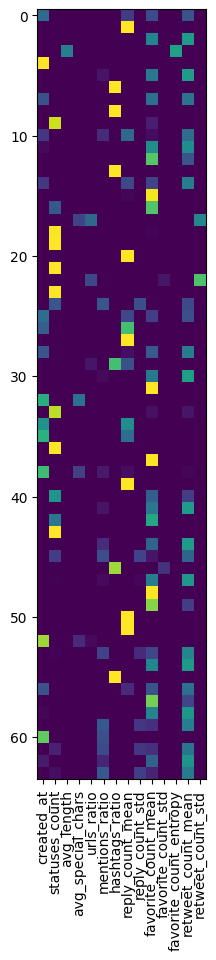

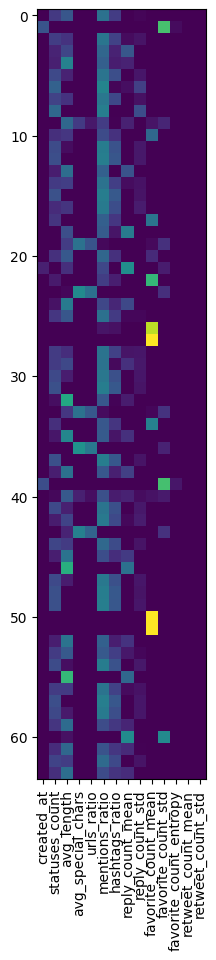

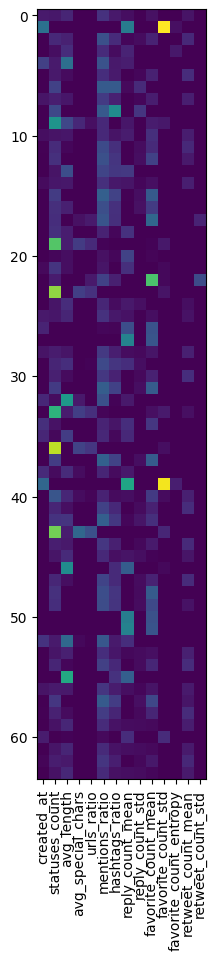

In [72]:
# Force eager execution mode to generate the masks
x, y = next(iter(ds_train))
_ = model(x)

for mask in model.tabnet.feature_selection_masks:
    fig, ax = plt.subplots(figsize=(5, 10))
    ax.imshow(mask[0])
    plt.xticks(range(len(numerical_features)), numerical_features, rotation="vertical") 
    plt.show()

    

fig, ax = plt.subplots(figsize=(5, 10))
ax.imshow(model.tabnet.aggregate_feature_selection_mask[0])
plt.xticks(range(len(numerical_features)), numerical_features, rotation="vertical") 
plt.show()


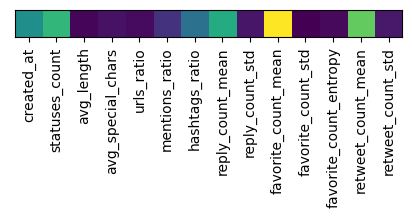

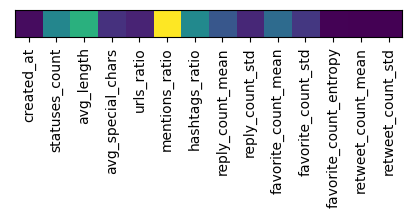

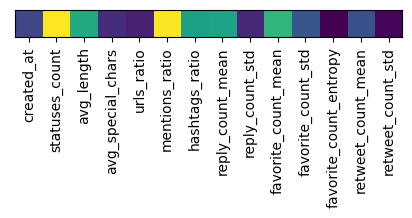

In [80]:
for mask in model.tabnet.feature_selection_masks:
    fig, ax = plt.subplots(figsize=(5, 10))
    ax.imshow([np.mean(mask[0], axis=0)])
    plt.xticks(range(len(numerical_features)), numerical_features, rotation="vertical")
    plt.yticks([])
    plt.show()

fig, ax = plt.subplots(figsize=(5, 10))
ax.imshow([np.mean(model.tabnet.aggregate_feature_selection_mask[0], axis=0)])
plt.xticks(range(len(numerical_features)), numerical_features, rotation="vertical")
plt.yticks([])
plt.show()